In [1]:
from eeg_learn_functions import *

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import re
from numpy import genfromtxt

%matplotlib inline
plt.style.use('ggplot')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["figure.figsize"] = (12,12)
pd.options.display.max_columns = None
pd.options.display.precision = 4

## Brainwave Frequencies:
Gamma, 30 to 50 Hz.  
Beta, 14 to 30 Hz.  
Alpha, 8 to 14 Hz.  
Theta, 4 to 8 Hz.  
Delta, 0.1 to 4 Hz.  

## Changing Bin Size: 
https://stackoverflow.com/questions/25735153/plotting-a-fast-fourier-transform-in-python  
(Search for 'bin')

An EEG processing library:  
https://github.com/pbashivan/EEGLearn

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import StratifiedKFold

def get_model(batch_size = 32, num_classes = 3, epochs = 200, input_shape = (28, 28, 3)):

    



    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(10))
    model.add(Activation('relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # initiate RMSprop optimizer
    opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])


    return model

Using TensorFlow backend.


In [4]:
delta = (0.1, 4)
theta = (4,8)
alpha = (8,14)
beta = (14,30)
gamma = (30, 50)

In [5]:
def get_fft(snippet):
    Fs = 128.0;  # sampling rate
    #Ts = len(snippet)/Fs/Fs; # sampling interval
    snippet_time = len(snippet)/Fs
    Ts = 1.0/Fs; # sampling interval
    t = np.arange(0,snippet_time,Ts) # time vector

    # ff = 5;   # frequency of the signal
    # y = np.sin(2*np.pi*ff*t)
    y = snippet
#     print('Ts: ',Ts)
#     print(t)
#     print(y.shape)
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(n//2)] # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(n//2)]
    #Added in: (To remove bias.)
    #Y[0] = 0
    return frq,abs(Y)
#f,Y = get_fft(np.hanning(len(snippet))*snippet)

In [6]:
def theta_alpha_beta_averages(f,Y):
    theta_range = (4,8)
    alpha_range = (8,12)
    beta_range = (12,40)
    theta = Y[(f>theta_range[0]) & (f<=theta_range[1])].mean()
    alpha = Y[(f>alpha_range[0]) & (f<=alpha_range[1])].mean()
    beta = Y[(f>beta_range[0]) & (f<=beta_range[1])].mean()
    return theta, alpha, beta

In [7]:
def make_steps(samples,frame_duration,overlap):
    '''
    in:
    samples - number of samples in the session
    frame_duration - frame duration in seconds 
    overlap - float fraction of frame to overlap in range (0,1)
    
    out: list of tuple ranges
    '''
    #steps = np.arange(0,len(df),frame_length)
    Fs = 128.0
    i = 0
    intervals = []
    samples_per_frame = 100#Fs * frame_duration
    while i+samples_per_frame <= samples:
        intervals.append((i,i+samples_per_frame))
        i = i + samples_per_frame - int(samples_per_frame*overlap)
    return intervals

In [8]:
def make_frames(df,frame_duration):
    '''
    in: dataframe or array with all channels, frame duration in seconds
    out: array of theta, alpha, beta averages for each probe for each time step
        shape: (n-frames,m-probes,k-brainwave bands)
    '''
    Fs = 128.0
    frame_length = 100#Fs*frame_duration
    frames = []
    steps = make_steps(len(df),frame_duration,overlap)
    for i,_ in enumerate(steps):
        frame = []
        if i == 0:
            continue
        else:
            for channel in df.columns:
                snippet = np.array(df.loc[steps[i][0]:steps[i][1],int(channel)])
                f,Y =  get_fft(snippet)
                theta, alpha, beta = theta_alpha_beta_averages(f,Y)
                frame.append([theta, alpha, beta])
            
        frames.append(frame)
    return np.array(frames)

In [9]:
locs_2d = [(-2.0,4.0),
           (2.0,4.0),
           (-1.0,3.0),
           (1.0,3.0),
           (-3.0,3.0),
           (3.0,3.0),
           (-2.0,2.0),
           (2.0,2.0),
           (-2.0,-2.0),
           (2.0,-2.0),
           (-4.0,1.0),
           (4.0,1.0),
           (-1.0,-3.0),
           (1.0,-3.0)]

In [10]:
from sklearn.preprocessing import StandardScaler, normalize
from sklearn import preprocessing
import pickle
def make_data_pipeline(file_names,labels,image_size,frame_duration,overlap, normalize = False):
    '''
    IN: 
    file_names - list of strings for each input file (one for each subject)
    labels - list of labels for each
    image_size - int size of output images in form (x, x)
    frame_duration - time length of each frame (seconds)
    overlap - float fraction of frame to overlap in range (0,1)
    
    OUT:
    X: np array of frames (unshuffled)
    y: np array of label for each frame (1 or 0)
    '''
    ##################################
    ###Still need to do the overlap###!!!
    ##################################
    
    Fs = 128.0   #sampling rate
    frame_length = 100#Fs * frame_duration
    
    print('Generating training data...')
    
    
    for i, file in enumerate(file_names):
        print ('Processing session: ',file, '. (',i+1,' of ',len(file_names),')')
        try:
            df = pd.read_csv(file)
            df = df[['EEG.AF3','EEG.F7','EEG.F3','EEG.FC5','EEG.T7','EEG.P7','EEG.O1','EEG.O2','EEG.P8','EEG.T8','EEG.FC6','EEG.F4','EEG.F8','EEG.AF4']]
        except:
            df = genfromtxt(file, delimiter=',')
            df = pd.DataFrame(df)
        df.columns = range(14)
        
        X_0 = make_frames(df,frame_duration)
        #steps = np.arange(0,len(df),frame_length)
        X_1 = X_0.reshape(len(X_0),14*3)
        
        images = gen_images(np.array(locs_2d),X_1, image_size, normalize=False)#, augment=True, pca=True, std_mult=0.1, n_components=7)
        images = np.swapaxes(images, 1, 3) 
        
        #print(len(images), ' frames generated with label ', labels[i], '.')
        print('\n')
        #print(pca_.explained_variance_ratio_)
        if i == 0:
            X = images
            y = np.ones(len(images))*labels[0]
        else:
            X = np.concatenate((X,images),axis = 0)
            y = np.concatenate((y,np.ones(len(images))*labels[i]),axis = 0)
    print(X.shape)
    if(normalize):
        X_r = X[:,:,:,0].reshape((X.shape[0]*image_size, image_size))
        X_g = X[:,:,:,1].reshape((X.shape[0]*image_size, image_size))
        X_b = X[:,:,:,2].reshape((X.shape[0]*image_size, image_size))

        X[:,:,:,0] = preprocessing.normalize(X_r).reshape((X.shape[0], X.shape[1], X.shape[2])) 
        X[:,:,:,1] = preprocessing.normalize(X_g).reshape((X.shape[0], X.shape[1], X.shape[2])) 
        X[:,:,:,2] = preprocessing.normalize(X_b).reshape((X.shape[0], X.shape[1], X.shape[2])) 
    
        #with open('scalers_dump.pickle', 'wb') as f:
        #    pickle.dump(scalers, f)
    return X,np.array(y)

In [48]:
from sklearn.model_selection import KFold
import keras
image_size = 28
frame_duration = 0.78
overlap = 0.5
num_classes = 3

#file_names = ['data/data_train_new_appr_1_label1.csv',
#              'data/data_train_new_appr_2_label0.csv',
#              'data/data_train_new_appr_3_label1.csv',
#              'data/data_train_new_appr_4_label0.csv',
#              'data/data_train_new_appr_6_label1.csv',
#              'data/data_train_new_appr_5_label0.csv',
#              'data/data_train_new_appr_8_label1.csv',
#              'data/data_train_new_appr_7_label0.csv',
#              'data/data_train_new_appr_10_label1.csv',
#              'data/data_train_new_appr_9_label0.csv',
#              'data/data_train_new_appr_12_label1.csv',
#              'data/data_train_new_appr_11_label0.csv',
#              'data/data_train_new_appr_14_label1.csv',
#              'data/data_train_new_appr_13_label0.csv',
#              'data/data_train_new_appr_15_label1.csv',
#              'data/data_train_new_appr_16_label0.csv',
#              'data/data_train_new_appr_17_label1.csv',
#              'data/data_train_new_appr_18_label0.csv',
#              'data/data_train_new_appr_19_label1.csv',
#              'data/data_train_new_appr_20_label0.csv'
#              ]
#    file_names_good = ['data/data_train_new_appr_10_label1.csv',  good rather
#                  'data/data_train_new_appr_9_label0.csv',
#                  'data/data_train_new_appr_12_label1.csv',
#                  'data/data_train_new_appr_11_label0.csv',
#                  'data/data_train_new_appr_14_label1.csv',
#                  'data/data_train_new_appr_13_label0.csv',
#                  'data/data_train_new_appr_21_label1.csv',
#                  'data/data_train_new_appr_22_label0.csv', 
#                  'data/data_train_new_appr_23_label1.csv',
#                  'data/data_train_new_appr_24_label0.csv' ,
#                       'data/data_train_new_appr_27_label1.csv',
#                      'data/data_train_new_appr_28_label0.csv']
#labels = [1,0,1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,  1, 0, 1, 0]
#labels_good = [1,0,1,0,1,0,1,0,1,0,1,0,1,0]
#file_names_good = ['data/3_labels/data_train_new_appr_1_label0.csv',
#                  'data/3_labels/data_train_new_appr_2_label1.csv',
#                  'data/3_labels/data_train_new_appr_3_label2.csv',
#                  'data/3_labels/data_train_new_appr_4_label0.csv',
#                  'data/3_labels/data_train_new_appr_5_label1.csv',
#                  'data/3_labels/data_train_new_appr_6_label2.csv']
file_names_good = ['data/3_labels/data_train_new_appr_1_label0.csv',
                  'data/3_labels/data_train_new_appr_2_label1.csv',
                  'data/3_labels/data_train_new_appr_3_label2.csv',
                  'data/3_labels/data_train_new_appr_4_label0.csv',
                  'data/3_labels/data_train_new_appr_5_label1.csv',
                  'data/3_labels/data_train_new_appr_6_label2.csv',
                  'data/3_labels/Data_new_7_label0.csv',
                  'data/3_labels/Data_new_8_label1.csv',
                  'data/3_labels/Data_new_9_label2.csv',
                  'data/3_labels/Data_new_10_label0.csv',
                  'data/3_labels/Data_new_11_label1.csv',
                  'data/3_labels/Data_new_12_label2.csv',
                  'data/3_labels/Data_new_13_label0.csv',
                  'data/3_labels/Data_new_14_label1.csv',
                  'data/3_labels/Data_new_15_label2.csv',
                  'data/3_labels/Data_new_16_label0.csv',
                  'data/3_labels/Data_new_17_label1.csv',
                  'data/3_labels/Data_new_18_label2.csv',
                  'data/3_labels/Data_new_19_label0.csv',
                  'data/3_labels/Data_new_20_label1.csv',
                  'data/3_labels/Data_new_21_label2.csv',
                  'data/3_labels/Data_new_22_label0.csv',
                  'data/3_labels/Data_new_23_label1.csv',
                  'data/3_labels/Data_new_24_label2.csv']
labels_good = [0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2]
X_transformed_list = []
y_transformed_list = []
for f_name, lbl in zip(file_names_good, labels_good):
    X, y = make_data_pipeline([f_name],[lbl],image_size,frame_duration,overlap, normalize = False)
    X = X.astype('float32')
    y = keras.utils.to_categorical(y, num_classes)
    X_transformed_list.append(X)
    y_transformed_list.append(y)
    print("Y: {}\n".format(y[0]))
X_transformed_list_np = np.array(X_transformed_list)
y_transformed_list_np = np.array(y_transformed_list)
X_transformed_list_np.shape



#X = tx[:].reshape((tx.shape[1]*tx.shape[0], 40, 40, 5))
#y = ty[:].reshape((ty.shape[1]*ty.shape[0], 3))

Generating training data...
Processing session:  data/3_labels/data_train_new_appr_1_label0.csv . ( 1  of  1 )
Interpolating 398/398nterpolating 39/398Interpolating 76/398Interpolating 116/398Interpolating 156/398Interpolating 199/398Interpolating 241/398Interpolating 281/398Interpolating 318/398Interpolating 357/398Interpolating 397/398

(398, 28, 28, 3)
Y: [1. 0. 0.]

Generating training data...
Processing session:  data/3_labels/data_train_new_appr_2_label1.csv . ( 1  of  1 )
Interpolating 398/398nterpolating 41/398Interpolating 80/398Interpolating 118/398Interpolating 197/398Interpolating 235/398Interpolating 274/398Interpolating 314/398Interpolating 353/398Interpolating 393/398

(398, 28, 28, 3)
Y: [0. 1. 0.]

Generating training data...
Processing session:  data/3_labels/data_train_new_appr_3_label2.csv . ( 1  of  1 )
Interpolating 398/398nterpolating 41/398Interpolating 83/398Interpolating 124/398Interpolating 164/398Interpolating 203/398Interpolating 242/398Interpolating 281/39

(24,)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(6041, 28, 28, 3)


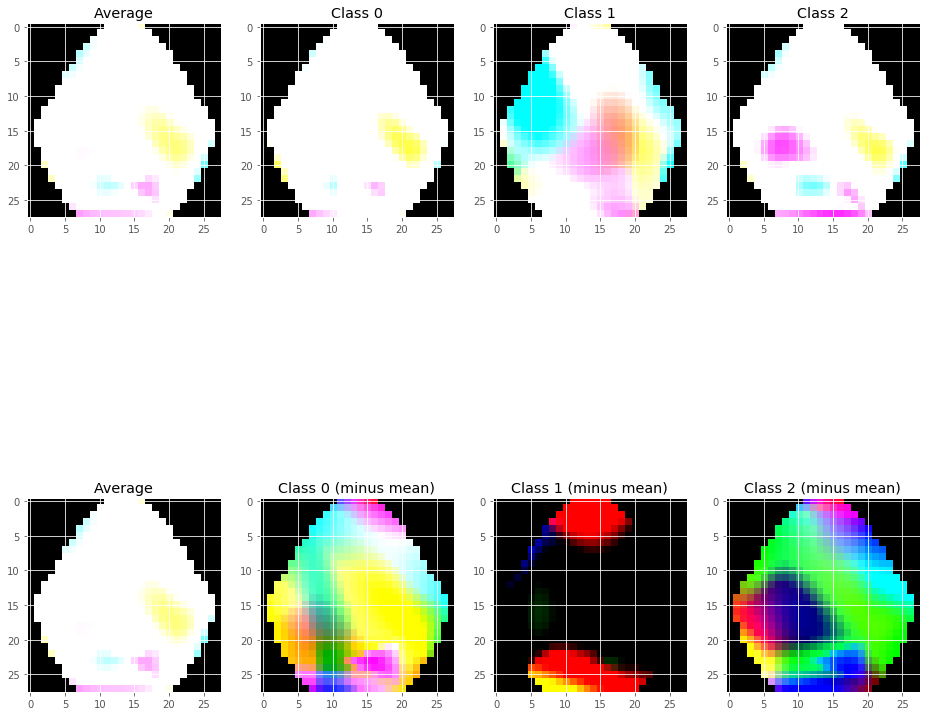

In [67]:
X_transformed_list_np = np.array(X_transformed_list)[6:]
y_transformed_list_np = np.array(y_transformed_list)[6:]

X_transformed_list_simp = np.array(X_transformed_list)[6:]
y_transformed_list_simp = np.array(X_transformed_list)[6:]

whole = np.concatenate((X_transformed_list_np), axis = 0)

#X_transformed_list_np = (X_transformed_list_np-whole.min())/(whole.max()-whole.min())

print(whole.shape)

whole = np.concatenate((X_transformed_list_np[:]), axis = 0)
mean = np.sum(whole, axis = 0)/whole.shape[0]


import matplotlib.pyplot as plt
%matplotlib inline


f, axarr = plt.subplots(2,4, figsize = (16,16))
axarr[0][0].set_title('Average')
axarr[0][0].imshow(mean)
axarr[0][1].set_title('Class 0')
axarr[0][1].imshow(X_transformed_list_np[0][200])
axarr[0][2].set_title('Class 1')
axarr[0][2].imshow(X_transformed_list_np[1][200])
axarr[0][3].set_title('Class 2')
axarr[0][3].imshow(X_transformed_list_np[2][200])
#

for i in range(X_transformed_list_np.shape[0]):
    X_transformed_list_np[i] = X_transformed_list_np[i] - mean

axarr[1][0].set_title('Average')
axarr[1][0].imshow(mean)
axarr[1][1].set_title('Class 0 (minus mean)')
axarr[1][1].imshow(X_transformed_list_np[0][200])
axarr[1][2].set_title('Class 1 (minus mean)')
axarr[1][2].imshow((X_transformed_list_np[1][200]))
axarr[1][3].set_title('Class 2 (minus mean)')
axarr[1][3].imshow((X_transformed_list_np[2][200]))



In [68]:
indexes = []
threshold =0
i = 0
batch_size = 32
while i+3 <= len(X_transformed_list_np):
    inds = {}
    inds['test'] = [i, i+1, i+2]
    inds['train'] = list(set(range(len(X_transformed_list_np)))-set(inds['test']))
    indexes.append(inds)
    print(inds['test'],inds['train'])
    i+=3
from sklearn.metrics import classification_report
report_list = {}
for ind in indexes:
    if(ind['test'][0] <= threshold):
        print()
        X_train, X_test, y_train, y_test = np.concatenate((X_transformed_list_simp[ind['train']]), axis = 0), \
        np.concatenate((X_transformed_list_simp[ind['test']]), axis = 0),  \
        np.concatenate((y_transformed_list_np[ind['train']]), axis = 0),  \
        np.concatenate((y_transformed_list_np[ind['test']]), axis = 0)
        model = get_model(epochs = 20)
        model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=200, 
              validation_data = (X_test, y_test), shuffle = True)


        report = classification_report(y_test.argmax(axis  = -1),   model.predict(X_test).argmax(axis = -1), target_names=['0','1', '2'])
        print(ind)
        print(report)
        report_list[str(ind)] = report

for ind in indexes:
    if(ind['test'][0] <= threshold):
        print()
        X_train, X_test, y_train, y_test = np.concatenate((X_transformed_list_np[ind['train']]), axis = 0), \
        np.concatenate((X_transformed_list_np[ind['test']]), axis = 0),  \
        np.concatenate((y_transformed_list_np[ind['train']]), axis = 0),  \
        np.concatenate((y_transformed_list_np[ind['test']]), axis = 0)
        model = get_model(epochs = 200)
        model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=50, 
              validation_data = (X_test, y_test), shuffle = True)


        report = classification_report(y_test.argmax(axis  = -1),   model.predict(X_test).argmax(axis = -1), target_names=['0','1', '2'])
        print(ind)
        print(report)
        report_list[str(ind)+"_meaned"] = report

[0, 1, 2] [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
[3, 4, 5] [0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
[6, 7, 8] [0, 1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 14, 15, 16, 17]
[9, 10, 11] [0, 1, 2, 3, 4, 5, 6, 7, 8, 12, 13, 14, 15, 16, 17]
[12, 13, 14] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 15, 16, 17]
[15, 16, 17] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

Train on 5038 samples, validate on 1003 samples
Epoch 1/200
5038/5038 [==============================] - 3s 511us/step - loss: 1.1026 - accuracy: 0.3261 - val_loss: 1.1038 - val_accuracy: 0.3340
Epoch 2/200
5038/5038 [==============================] - 2s 438us/step - loss: 1.0979 - accuracy: 0.3418 - val_loss: 1.1039 - val_accuracy: 0.3589
Epoch 3/200
5038/5038 [==============================] - 2s 440us/step - loss: 1.0958 - accuracy: 0.3620 - val_loss: 1.1102 - val_accuracy: 0.3509
Epoch 4/200
5038/5038 [==============================] - 2s 438us/step - loss: 1.0883 - accuracy: 0.3684 - val_loss: 1.1077 - 

5038/5038 [==============================] - 2s 439us/step - loss: 0.7727 - accuracy: 0.6566 - val_loss: 1.6208 - val_accuracy: 0.4018
Epoch 109/200
5038/5038 [==============================] - 2s 439us/step - loss: 0.7680 - accuracy: 0.6612 - val_loss: 1.5105 - val_accuracy: 0.3938
Epoch 110/200
5038/5038 [==============================] - 2s 441us/step - loss: 0.7650 - accuracy: 0.6663 - val_loss: 1.6374 - val_accuracy: 0.4008
Epoch 111/200
5038/5038 [==============================] - 2s 453us/step - loss: 0.7604 - accuracy: 0.6755 - val_loss: 1.5968 - val_accuracy: 0.3799
Epoch 112/200
5038/5038 [==============================] - 2s 440us/step - loss: 0.7621 - accuracy: 0.6634 - val_loss: 1.5846 - val_accuracy: 0.3878
Epoch 113/200
5038/5038 [==============================] - 2s 438us/step - loss: 0.7616 - accuracy: 0.6673 - val_loss: 1.4960 - val_accuracy: 0.3809
Epoch 114/200
5038/5038 [==============================] - 2s 441us/step - loss: 0.7577 - accuracy: 0.6671 - val_loss: 1

5038/5038 [==============================] - 2s 436us/step - loss: 0.6888 - accuracy: 0.7019 - val_loss: 1.7443 - val_accuracy: 0.3809
Epoch 164/200
5038/5038 [==============================] - 2s 437us/step - loss: 0.6885 - accuracy: 0.7076 - val_loss: 1.7998 - val_accuracy: 0.3978
Epoch 165/200
5038/5038 [==============================] - 2s 437us/step - loss: 0.6869 - accuracy: 0.7023 - val_loss: 1.9764 - val_accuracy: 0.3988
Epoch 166/200
5038/5038 [==============================] - 2s 439us/step - loss: 0.6861 - accuracy: 0.7035 - val_loss: 1.8036 - val_accuracy: 0.3988
Epoch 167/200
5038/5038 [==============================] - 2s 437us/step - loss: 0.6859 - accuracy: 0.7078 - val_loss: 1.7005 - val_accuracy: 0.3938
Epoch 168/200
5038/5038 [==============================] - 2s 436us/step - loss: 0.6789 - accuracy: 0.7108 - val_loss: 1.7241 - val_accuracy: 0.4018
Epoch 169/200
5038/5038 [==============================] - 2s 435us/step - loss: 0.6800 - accuracy: 0.7076 - val_loss: 1

Epoch 15/50
5038/5038 [==============================] - 2s 439us/step - loss: 0.8243 - accuracy: 0.6237 - val_loss: 1.3209 - val_accuracy: 0.3689
Epoch 16/50
5038/5038 [==============================] - 2s 441us/step - loss: 0.8128 - accuracy: 0.6262 - val_loss: 1.3519 - val_accuracy: 0.3629
Epoch 17/50
5038/5038 [==============================] - 2s 441us/step - loss: 0.8039 - accuracy: 0.6318 - val_loss: 1.3052 - val_accuracy: 0.3669
Epoch 18/50
5038/5038 [==============================] - 2s 439us/step - loss: 0.7983 - accuracy: 0.6407 - val_loss: 1.2898 - val_accuracy: 0.3729
Epoch 19/50
5038/5038 [==============================] - 2s 439us/step - loss: 0.7853 - accuracy: 0.6391 - val_loss: 1.3727 - val_accuracy: 0.3868
Epoch 20/50
5038/5038 [==============================] - 2s 440us/step - loss: 0.7784 - accuracy: 0.6441 - val_loss: 1.3747 - val_accuracy: 0.3689
Epoch 21/50
5038/5038 [==============================] - 2s 440us/step - loss: 0.7690 - accuracy: 0.6522 - val_loss: 1

In [69]:
for a in report_list:
    print(report_list[a])

              precision    recall  f1-score   support

           0       0.27      0.16      0.20       332
           1       0.38      0.59      0.47       335
           2       0.48      0.42      0.44       336

    accuracy                           0.39      1003
   macro avg       0.38      0.39      0.37      1003
weighted avg       0.38      0.39      0.37      1003

              precision    recall  f1-score   support

           0       0.32      0.09      0.14       332
           1       0.37      0.77      0.50       335
           2       0.53      0.34      0.41       336

    accuracy                           0.40      1003
   macro avg       0.41      0.40      0.35      1003
weighted avg       0.41      0.40      0.35      1003



In [35]:
y

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


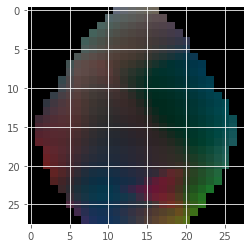

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_transformed_list_np[2][202]);

IndexError: index 3 is out of bounds for axis 0 with size 3

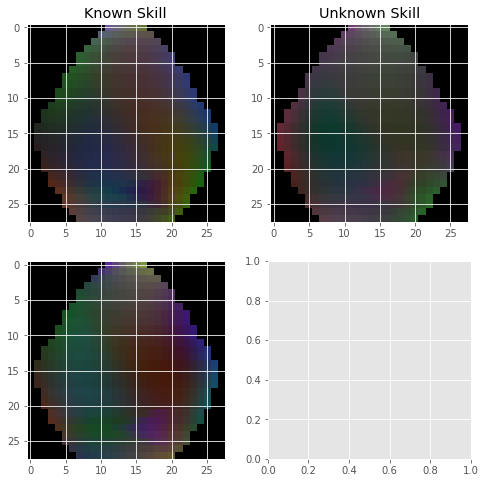

In [58]:
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(2,2, figsize = (8,8))
axarr[0][0].set_title('Known Skill')
axarr[0][0].imshow(X_transformed_list_np[0][0])
axarr[1][0].imshow(X_transformed_list_np[1][0])

axarr[0][1].set_title('Unknown Skill')
axarr[0][1].imshow(X_transformed_list_np[2][0])
axarr[1][1].imshow(X_transformed_list_np[3][0])

;

In [25]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.01,shuffle=True)

In [24]:
X_train, y_train = np.concatenate((X_transformed_list_np[0:21]), axis = 0), np.concatenate((y_transformed_list_np[0:21]), axis = 0)  
X_test, y_test = np.concatenate((X_transformed_list_np[21:]), axis = 0), np.concatenate((y_transformed_list_np[21:]), axis = 0)  

In [28]:
# input image dimensions
img_rows, img_cols = 28, 28
import keras
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
X_test = X_test.astype('float32')
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Y_test = keras.utils.to_categorical(Y_test, num_classes)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

input_shape = (img_rows, img_cols, 3)

Using TensorFlow backend.


NameError: name 'num_classes' is not defined

In [25]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import StratifiedKFold
batch_size = 32
num_classes = 3
epochs = 200
input_shape = (28, 28, 3)



model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(10))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs, 
          validation_data = (X_test, y_test), shuffle = True)

model.save('80_model.h5')

Train on 3684 samples, validate on 500 samples
Epoch 1/200
3684/3684 [==============================] - 2s 539us/step - loss: 1.1003 - accuracy: 0.3540 - val_loss: 1.0975 - val_accuracy: 0.3300
Epoch 2/200
3684/3684 [==============================] - 2s 413us/step - loss: 1.0754 - accuracy: 0.4121 - val_loss: 1.1162 - val_accuracy: 0.3600
Epoch 3/200
3684/3684 [==============================] - 2s 417us/step - loss: 1.0586 - accuracy: 0.4297 - val_loss: 1.0993 - val_accuracy: 0.3660
Epoch 4/200
3684/3684 [==============================] - 2s 418us/step - loss: 1.0395 - accuracy: 0.4449 - val_loss: 1.1668 - val_accuracy: 0.3240
Epoch 5/200
3684/3684 [==============================] - 2s 414us/step - loss: 1.0254 - accuracy: 0.4750 - val_loss: 1.3382 - val_accuracy: 0.3300
Epoch 6/200
3684/3684 [==============================] - 2s 420us/step - loss: 1.0159 - accuracy: 0.4878 - val_loss: 1.1711 - val_accuracy: 0.3460
Epoch 7/200
3684/3684 [==============================] - 2s 420us/step 

3684/3684 [==============================] - 2s 409us/step - loss: 0.6028 - accuracy: 0.7440 - val_loss: 1.7623 - val_accuracy: 0.2620
Epoch 112/200
3684/3684 [==============================] - 2s 411us/step - loss: 0.6055 - accuracy: 0.7473 - val_loss: 1.5974 - val_accuracy: 0.3760
Epoch 113/200
3684/3684 [==============================] - 2s 412us/step - loss: 0.5983 - accuracy: 0.7427 - val_loss: 1.8769 - val_accuracy: 0.2260
Epoch 114/200
3684/3684 [==============================] - 2s 412us/step - loss: 0.6017 - accuracy: 0.7408 - val_loss: 1.7457 - val_accuracy: 0.2820
Epoch 115/200
3684/3684 [==============================] - 2s 417us/step - loss: 0.5991 - accuracy: 0.7432 - val_loss: 1.5451 - val_accuracy: 0.3880
Epoch 116/200
3684/3684 [==============================] - 2s 409us/step - loss: 0.5957 - accuracy: 0.7473 - val_loss: 1.4751 - val_accuracy: 0.3640
Epoch 117/200
3684/3684 [==============================] - 2s 414us/step - loss: 0.5906 - accuracy: 0.7484 - val_loss: 1

3684/3684 [==============================] - 2s 412us/step - loss: 0.5142 - accuracy: 0.7880 - val_loss: 2.6284 - val_accuracy: 0.3860
Epoch 167/200
3684/3684 [==============================] - 2s 412us/step - loss: 0.5215 - accuracy: 0.7877 - val_loss: 2.1309 - val_accuracy: 0.4340
Epoch 168/200
3684/3684 [==============================] - 2s 414us/step - loss: 0.5144 - accuracy: 0.7869 - val_loss: 1.8225 - val_accuracy: 0.3960
Epoch 169/200
3684/3684 [==============================] - 2s 413us/step - loss: 0.5133 - accuracy: 0.7896 - val_loss: 1.7961 - val_accuracy: 0.3060
Epoch 170/200
3684/3684 [==============================] - 2s 426us/step - loss: 0.5125 - accuracy: 0.7837 - val_loss: 1.8089 - val_accuracy: 0.2280
Epoch 171/200
3684/3684 [==============================] - 2s 421us/step - loss: 0.5149 - accuracy: 0.7866 - val_loss: 1.8203 - val_accuracy: 0.2920
Epoch 172/200
3684/3684 [==============================] - 2s 419us/step - loss: 0.5040 - accuracy: 0.7910 - val_loss: 1

In [26]:
from sklearn.metrics import classification_report

report = classification_report(y_test.argmax(axis  = -1),   model.predict(X_test).argmax(axis = -1), target_names=['0','1', '2'])
print(report)

              precision    recall  f1-score   support

           0       0.34      0.62      0.44       166
           1       0.14      0.05      0.07       167
           2       0.49      0.39      0.43       167

    accuracy                           0.35       500
   macro avg       0.32      0.35      0.31       500
weighted avg       0.32      0.35      0.31       500



In [79]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import StratifiedKFold
batch_size = 32
num_classes = 2
epochs = 110

# convert class vectors to binary class matrices

kf = StratifiedKFold(n_splits=5, shuffle = True)
acc_row = []
lst = []
for train_index, test_index in kf.split(X, y):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(10))
    model.add(Activation('relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # initiate RMSprop optimizer
    opt = keras.optimizers.rmsprop(lr=0.01, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    #x_train = x_train.astype('float32')
    #x_test = x_test.astype('float32')
    #x_train /= 255
    #x_test /= 255


    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_split = 0.1, class_weight = {0:1,1:1})
    lst.append(model.evaluate(x_test, y_test))
    print(lst)

Train on 3438 samples, validate on 382 samples
Epoch 1/110
3438/3438 [==============================] - 2s 626us/step - loss: 0.9282 - accuracy: 0.5564 - val_loss: 0.9801 - val_accuracy: 0.3770
Epoch 2/110
3438/3438 [==============================] - 2s 461us/step - loss: 0.6803 - accuracy: 0.6172 - val_loss: 1.0249 - val_accuracy: 0.2618
Epoch 3/110
 544/3438 [===>..........................] - ETA: 1s - loss: 0.6203 - accuracy: 0.6489

KeyboardInterrupt: 

In [19]:
model.save('path_to_my_model.h5')

In [57]:
model.evaluate(x_test, y_test)

24/24 [==============================] - 0s 250us/step


[0.7046559453010559, 0.625]

In [24]:
from test_pipeline_3 import  TestPipelineEEG
import pandas as pd
import pickle
import numpy as np
predictor = TestPipelineEEG(image_size = 28, frame_duration = 0.78, overlap = 0.0, model_path = '80_model.h5', normalize = True)
data = pd.read_csv('data/data_train_new_appr_8_label0.csv')
data.columns = range(14)
overlap = 0.0#75
lst = []
i = 0
while (i+100) <= data.shape[0]:
    lst.append(predictor.evaluate(data.iloc[i:i+100]))
    i = i + 100 - int(100*overlap)
print("Accuracy = {}".format(1-np.sum(lst)/len(lst)))
i = 0
data = pd.read_csv('data/data_train_new_appr_7_label1.csv')
data.columns = range(14)
lst = []
while i+100 <= data.shape[0]:
    lst.append(predictor.evaluate(data.iloc[i:i+100]))
    i = i + 100 - int(100*overlap)
print("Accuracy = {}".format(np.sum(lst)/len(lst)))

Accuracy = 0.5549999999999999
Accuracy = 0.245


In [90]:
y.sum()

2388.0

In [91]:
y.shape

(4776,)